# PanArctic DSL - Download Copernicus Marine data

Pierre Priou 2022-03-03

## Packages loading

The Copernicus Marine Environment Monitoring Service (CMEMS) requires `motuclient` for downloading data. Here, I download monthly physical data—temperature, salinity, and current velocities—from the Hybrid Coordinate Ocean Model (HYCOM) over several depth (0, 222, 380, 644, 1062 m depth). For help downloading data check the [Copernicus help](https://help.marine.copernicus.eu/en/articles/5211063-how-to-use-the-motuclient-within-python-environment-e-g-spyder).

In [1]:
import os
import getpass
import motuclient
import datetime as dt
import pandas as pd
import xarray as xr # For reading NetCDF files

Define functions used for downloading CMEMS data.

In [2]:
# Define MotuOptions class
class MotuOptions:
    def __init__(self, attrs: dict):
        super(MotuOptions, self).__setattr__("attrs", attrs)

    def __setattr__(self, k, v):
        self.attrs[k] = v

    def __getattr__(self, k):
        try:
            return self.attrs[k]
        except KeyError:
            return None

In [3]:
# Define motu_option_parser
def motu_option_parser(script_template, usr, pwd, output_directory):
    dictionary = dict(
        [e.strip().partition(" ")[::2] for e in script_template.split('--')])
    dictionary['variable'] = [value for (var, value) in [e.strip().partition(" ")[::2] for e in script_template.split('--')] if var == 'variable']  # pylint: disable=line-too-long
    for k, v in list(dictionary.items()):
        if v == '<OUTPUT_DIRECTORY>':
            dictionary[k] = output_directory
        #if v == '<OUTPUT_FILENAME>':
        #    dictionary[k] = output_filename
        if v == '<USERNAME>':
            dictionary[k] = usr
        if v == '<PASSWORD>':
            dictionary[k] = pwd
        if k in ['longitude-min', 'longitude-max', 'latitude-min', 
                 'latitude-max', 'depth-min', 'depth-max']:
            dictionary[k] = float(v)
        if k in ['date-min', 'date-max']:
            dictionary[k] = v[1:-1]
        dictionary[k.replace('-','_')] = dictionary.pop(k)
    dictionary.pop('python')
    dictionary['auth_mode'] = 'cas'
    return dictionary

Load credentials.

In [4]:
USERNAME = input('Enter your username: ')
PASSWORD = getpass.getpass('Enter your password: ')

Enter your username: ppriou
Enter your password: ········


## Download data

Setup the `motuclient` template command line. Datasets requests are retrieved from the Copernicus website ([more info here](https://help.marine.copernicus.eu/en/articles/4899195-how-to-generate-and-run-a-script-to-download-a-subset-of-a-dataset-from-the-copernicus-marine-data-store#h_dee5a134b1)) and pasted below.

### Arctic Ocean Physics Reanalysis

I download the [ARCTIC_MULTIYEAR_PHY_002_003-TDS](https://resources.marine.copernicus.eu/product-detail/ARCTIC_MULTIYEAR_PHY_002_003/INFORMATION). Data resolution is 12.5 x 12.5 km on a Polar stereographic North projection.

Define the geographical area and timeseries subset that I want to download. Data is averaged on the 15th of every month.

In [5]:
# Area definition
lon_min = -155
lon_max = 40
lat_min = 60
lat_max = 85

# Date definitions
date_start = dt.datetime(2014, 12, 15)
date_end = dt.datetime(2017, 12, 15)
daterange = pd.date_range(date_start, date_end, freq = "MS") + pd.DateOffset(days=14)

Set output directory.

In [21]:
OUTPUT_DIRECTORY = 'data/remote_sensing/physics/phy_266_318m'

In [12]:
# Depths of interest
depth = [266, 318]

Setup the for loop to download data.

In [23]:
for z in depth:
    for date in daterange:
        request_tmp = 'python -m motuclient \
        --motu https://my.cmems-du.eu/motu-web/Motu \
        --service-id ARCTIC_MULTIYEAR_PHY_002_003-TDS \
        --product-id cmems_mod_arc_phy_my_topaz4_P1M \
        --longitude-min '+ str(lon_min) +' \
        --longitude-max '+ str(lon_max) +' \
        --latitude-min '+ str(lat_min) +' \
        --latitude-max '+ str(lat_max) +' \
        --date-min "'+ str(date) +'" \
        --date-max "'+ str(date) +'" \
        --depth-min '+ str(z) +' \
        --depth-max '+ str(z) +' \
        --variable latitude --variable longitude --variable mlotst --variable siconc \
        --variable sithick --variable so --variable thetao --variable vxo --variable vyo \
        --out-dir <OUTPUT_DIRECTORY> \
        --out-name '+ str(date.year) + str(f"{date:%m}") + str(f"{date:%d}") + "_" + str(z) + "m_phy_CMEMS.nc" +' \
        --user <USERNAME> --pwd <PASSWORD>'
        print("Downloading " + str(date.year) + "-" + str(f"{date:%m}") + "-" + str(f"{date:%d}") + " " + str(z) + " m")
        # Setup request
        data_request_options_dict_automated = motu_option_parser(request_tmp, USERNAME, PASSWORD, OUTPUT_DIRECTORY)
        # Download requested data
        motuclient.motu_api.execute_request(MotuOptions(data_request_options_dict_automated))
        if date == daterange[-1]:
            print("Download " + str(z) + "m finished.")

Download 266m finished.
Download 318m finished.


Data is downloaded as NetCDF. I then combine them and analyzed them in R.

#### Data check

Open, read, and plot the NetCDF I just downloaded to check whether it worked or not.

In [31]:
# Open and read a file
PHY = xr.open_dataset(OUTPUT_DIRECTORY + "/20150716_0m_phy_CMEMS.nc")
print(PHY)

<xarray.Dataset>
Dimensions:        (depth: 1, time: 1, x: 546, y: 367)
Coordinates:
    latitude       (y, x) float32 ...
  * depth          (depth) float32 0.0
  * x              (x) float32 -34.125 -34.0 -33.875 ... 33.75 33.875 34.0
  * y              (y) float32 -34.125 -34.0 -33.875 ... 11.375 11.5 11.625
  * time           (time) datetime64[ns] 2015-02-15
    longitude      (y, x) float32 ...
Data variables:
    mlotst         (time, y, x) float32 ...
    siconc         (time, y, x) float32 ...
    thetao         (time, depth, y, x) float32 ...
    sithick        (time, y, x) float32 ...
    vxo            (time, depth, y, x) float32 ...
    vyo            (time, depth, y, x) float32 ...
    stereographic  int32 ...
    so             (time, depth, y, x) float32 ...
Attributes:
    institution:                     NERSC, Thormoehlens gate 47, N-5006 Berg...
    history:                         20211013:Created by program hyc2proj, ve...
    source:                          NERSC

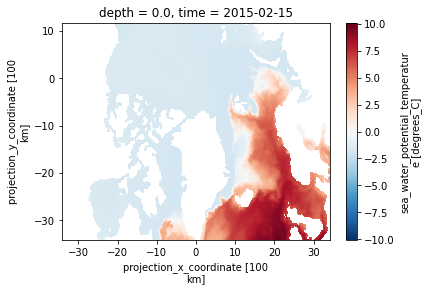

In [27]:
# Plot map of potential temperature at 0 m for Feburary 2015
PHY.thetao.sel().plot()

### Global Ocean Biogeochemsitry Hindcast

I download the [GLOBAL_MULTIYEAR_BGC_001_029](https://resources.marine.copernicus.eu/product-detail/GLOBAL_MULTIYEAR_BGC_001_029/INFORMATION). Data resolution is 0.25 x 0.25 degrees on a ETRS89 (EPSG 4258)  projection.

Define the geographical area and timeseries subset that I want to download. Data is a bit messy and is generally averaged on the 16th of every month, except for February when it is averaged on the 15th. The averaging hours alternates between 00:00:00 and 12:00:00 with no real pattern eiter. So I download data for each year speratately. 

In [60]:
# Area definition
lon_min = -180
lon_max = 179.75
lat_min = 60
lat_max = 90

Set output directory.

In [61]:
OUTPUT_DIRECTORY = 'data/remote_sensing/biogeochemistry/nc'

Setup the for loop to download data.

### 2015

In [65]:
request_tmp = 'python -m motuclient \
--motu https://my.cmems-du.eu/motu-web/Motu \
--service-id GLOBAL_MULTIYEAR_BGC_001_029-TDS \
--product-id cmems_mod_glo_bgc_my_0.25_P1M-m  \
--longitude-min '+ str(lon_min) +' \
--longitude-max '+ str(lon_max) +' \
--latitude-min '+ str(lat_min) +' \
--latitude-max '+ str(lat_max) +' \
--date-min "2015-01-16 12:00:00" \
--date-max "2015-12-16 12:00:00" \
--depth-min 0.5057 \
--depth-max 0.5058 \
--variable chl --variable nppv --variable o2 \
--out-dir <OUTPUT_DIRECTORY> \
--out-name 2015_1m_chl_CMEMS.nc \
--user <USERNAME> --pwd <PASSWORD>'
print("Downloading 2015 data at 1 m")
# Setup request
data_request_options_dict_automated = motu_option_parser(request_tmp, USERNAME, PASSWORD, OUTPUT_DIRECTORY)
# Download requested data
motuclient.motu_api.execute_request(MotuOptions(data_request_options_dict_automated))
print("Finished downloading.")

Finished downloading.


### 2016

In [67]:
request_tmp = 'python -m motuclient \
--motu https://my.cmems-du.eu/motu-web/Motu \
--service-id GLOBAL_MULTIYEAR_BGC_001_029-TDS \
--product-id cmems_mod_glo_bgc_my_0.25_P1M-m  \
--longitude-min '+ str(lon_min) +' \
--longitude-max '+ str(lon_max) +' \
--latitude-min '+ str(lat_min) +' \
--latitude-max '+ str(lat_max) +' \
--date-min "2016-01-16 12:00:00" \
--date-max "2016-12-16 12:00:00" \
--depth-min 0.5057 \
--depth-max 0.5058 \
--variable chl --variable nppv --variable o2 \
--out-dir <OUTPUT_DIRECTORY> \
--out-name 2016_1m_chl_CMEMS.nc \
--user <USERNAME> --pwd <PASSWORD>'
print("Downloading 2016 data at 1 m")
# Setup request
data_request_options_dict_automated = motu_option_parser(request_tmp, USERNAME, PASSWORD, OUTPUT_DIRECTORY)
# Download requested data
motuclient.motu_api.execute_request(MotuOptions(data_request_options_dict_automated))
print("Finished downloading.")

Finished downloading.


### 2017

In [68]:
request_tmp = 'python -m motuclient \
--motu https://my.cmems-du.eu/motu-web/Motu \
--service-id GLOBAL_MULTIYEAR_BGC_001_029-TDS \
--product-id cmems_mod_glo_bgc_my_0.25_P1M-m  \
--longitude-min '+ str(lon_min) +' \
--longitude-max '+ str(lon_max) +' \
--latitude-min '+ str(lat_min) +' \
--latitude-max '+ str(lat_max) +' \
--date-min "2017-01-16 12:00:00" \
--date-max "2017-12-16 12:00:00" \
--depth-min 0.5057 \
--depth-max 0.5058 \
--variable chl --variable nppv --variable o2 \
--out-dir <OUTPUT_DIRECTORY> \
--out-name 2017_1m_chl_CMEMS.nc \
--user <USERNAME> --pwd <PASSWORD>'
print("Downloading 2017 data at 1 m")
# Setup request
data_request_options_dict_automated = motu_option_parser(request_tmp, USERNAME, PASSWORD, OUTPUT_DIRECTORY)
# Download requested data
motuclient.motu_api.execute_request(MotuOptions(data_request_options_dict_automated))
print("Finished downloading.")

Finished downloading.


### Ocean colour - Monthly chlorophyll a concentrations

I download the [OCEANCOLOUR_ARC_CHL_L4_REP_OBSERVATIONS_009_088](https://resources.marine.copernicus.eu/product-detail/OCEANCOLOUR_ARC_CHL_L4_REP_OBSERVATIONS_009_088/INFORMATION). Data resolution is 1 x 1 km on a  WGS 84 / Plate Carree (EPSG 32662) projection.

In [6]:
# Area definition
lon_min = -179.95
lon_max = 179.95
lat_min = 66.5
lat_max = 85

# Date definitions
date_start = dt.datetime(2016, 1, 1, 0, 0, 0)
date_end = dt.datetime(2017, 12, 1, 0, 0, 0)
daterange = pd.date_range(date_start, date_end, freq = "MS")

Set output directory.

In [7]:
OUTPUT_DIRECTORY = 'data/remote_sensing/ocean_colour/nc'

Setup the for loop to download data.

In [8]:
for date in daterange:
    request_tmp = 'python -m motuclient \
    --motu https://my.cmems-du.eu/motu-web/Motu \
    --service-id OCEANCOLOUR_ARC_CHL_L4_REP_OBSERVATIONS_009_088-TDS \
    --product-id dataset-oc-arc-chl-multi_cci-l4-chl_1km_monthly-rep-v02 \
    --longitude-min '+ str(lon_min) +' \
    --longitude-max '+ str(lon_max) +' \
    --latitude-min '+ str(lat_min) +' \
    --latitude-max '+ str(lat_max) +' \
    --date-min "'+ str(date) +'" \
    --date-max "'+ str(date) +'" \
    --variable CHL --variable grid_mapping \
    --out-dir <OUTPUT_DIRECTORY> \
    --out-name '+ str(date.year) + str(f"{date:%m}") + str(f"{date:%d}") + "_chl_CMEMS.nc" +' \
    --user <USERNAME> --pwd <PASSWORD>'
    print("Downloading chl " + str(date.year) + "-" + str(f"{date:%m}") + "-" + str(f"{date:%d}"))
    # Setup request
    data_request_options_dict_automated = motu_option_parser(request_tmp, USERNAME, PASSWORD, OUTPUT_DIRECTORY)
    # Download requested data
    motuclient.motu_api.execute_request(MotuOptions(data_request_options_dict_automated))
    if date == daterange[-1]:
        print("Download finished.")

Download finished.
